In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = 40,10
plt.rcParams["font.size"] = 15

In [5]:
from one.utils import *
from one.data.ucrdata import UcrDataReader

In [6]:
ROOT_DIR = "./data/ucr/"
t = get_files_from_path("./data/ucr")

In [7]:
d = UcrDataReader()
test = d(ROOT_DIR+t[161])

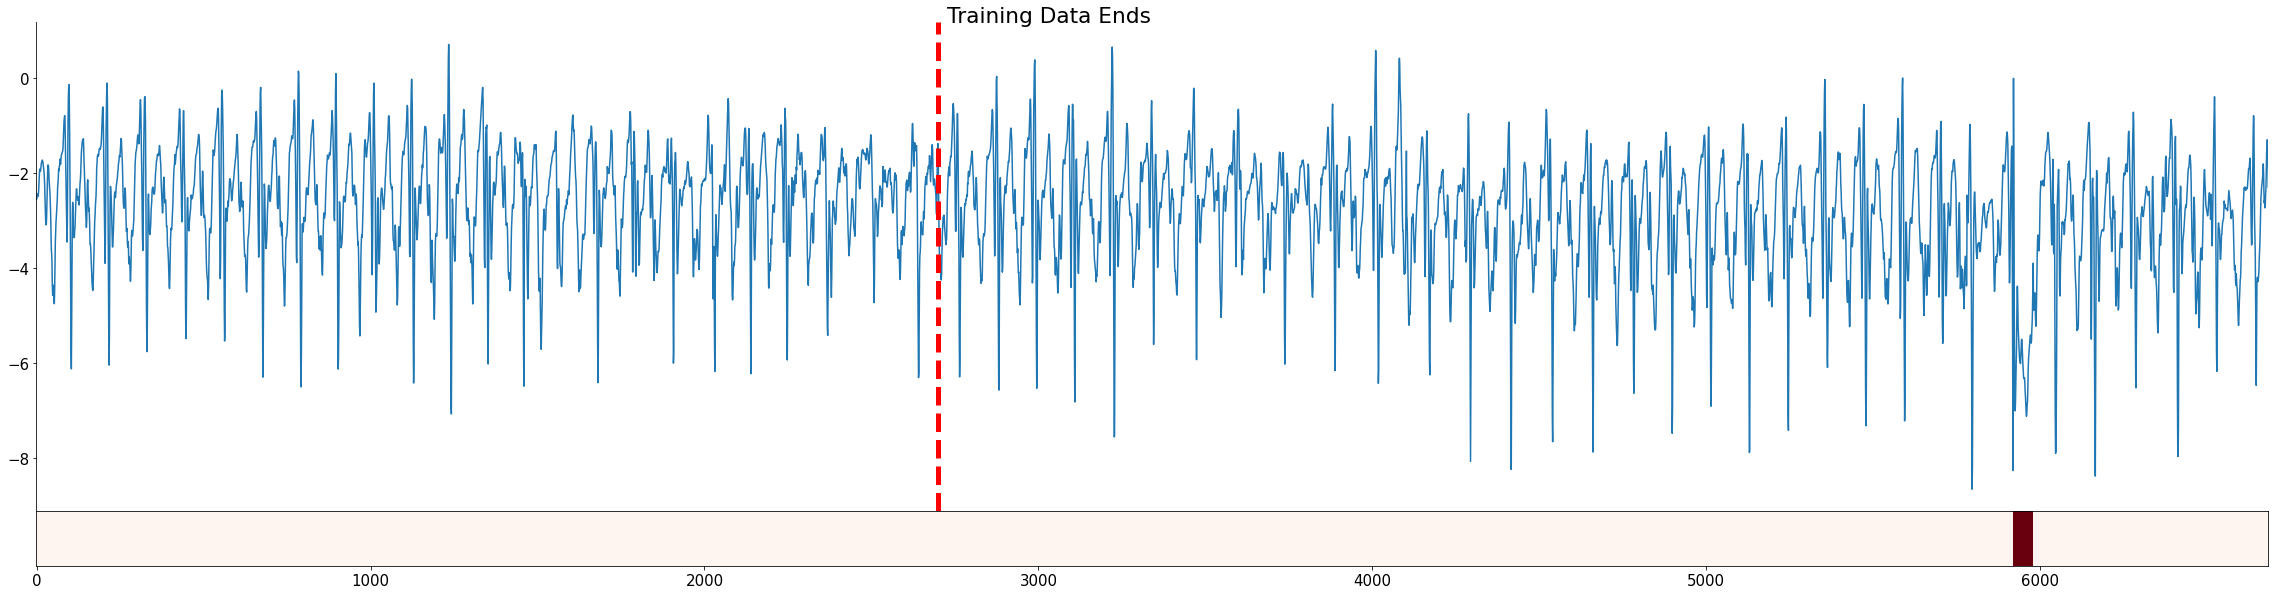

In [8]:
p = graph_data(test.series, test.labels, test.train_len)

# Experiment

In [ ]:
import os 

from one.utils import *
from one.models import *
from one.data.ucrdata import UcrDataReader

In [ ]:
ROOT_DIR = "./data/ucr/"
SAVE_DIR = "./results/"

SIMPLE_MODELS = [LightGBMModel, RandomForestModel, RegressionModel]
DL_MODELS = [NBEATSModel, NHiTSModel, TCNModel, TFTModel, TransformerModel]
RNN_MODELS = ["RNN", "LSTM", "GRU"]

files = get_files_from_path(ROOT_DIR)

In [ ]:
def run_model(m, data, fdir):
        os.makedirs(fdir, exist_ok=True)
        
        train_data, train_label = data.train
        test_data, test_label = data.test
        
        m.hyperopt_ws(train_data, test_data, 30)

        model_test_data, model_test_label = data.get_test_with_window(m.window)
        
        m.hyperopt_model(train_data, model_test_data, 50)
        m.fit(train_data)

        score, _, preds = m.get_scores(model_test_data)

        save_model_output(score, m, f"{fdir}{m.model_name}_scores.txt")
        save_model_output(preds, m, f"{fdir}{m.model_name}_preds.txt")

In [ ]:
reader = UcrDataReader()

for file in files:
    data_name = file.split(".")[0]
    data = reader(ROOT_DIR+file)
    fdir = f"{SAVE_DIR}{data_name}/"
    
    for model in MODELS:
        m = model()
        run_model(m, data, fdir)
        
    for model in DL_Models:
        m = model(use_gpu=True, val_split=0.1)
        run_model(m, data, fdir)

    for model in RNN_MODELS:
        m = RNNModel(use_gpu=True, rnn_model=model, val_split=0.1)
        run_model(m, data, fdir)
        
        

        

In [ ]:
m.__class__(100)

In [ ]:
m

In [ ]:
from one.models.predictive.nbeats import NBEATSModel

In [ ]:
def hypertune(params: dict):
    w = int(params.get("w"))
    s = int(params.get("s"))
    
    tr_data, tr_label = test.train
    test_data, test_label = test.get_test_with_window(w)
    
    model = NBEATSModel(w, s, True, val_split=max(0.10, (w+s)/len(tr_data)+0.01) )
    model.fit(tr_data)
    score, res, _ = model.get_scores(test_data)
    # return np.average(acf(score, fft=False, nlags=5)).item()
    return np.sum(res**2)


In [ ]:
from hyperopt import fmin, tpe, hp
from statsmodels.tsa.stattools import acf


best = fmin(hypertune,
    space= {'w': hp.quniform("w", 20, 0.2*len(test.train[0]), 5), 
            "s": hp.quniform("s", 1, 20, 1)},
    algo=tpe.suggest,
    max_evals=20)

In [ ]:
best

In [ ]:
w = 160
s = 2

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.get_test_with_window(w)

In [ ]:
model = NBEATSModel(w, s, True, val_split=0.15)

In [ ]:
model.fit(tr_data)

In [ ]:
score, res, preds = model.get_scores(test_data)

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(score)
a.plot(test.test[1])
b.plot(test.test[0])

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(preds)
b.plot(test.test[0])

In [ ]:
import seaborn as sns

sns.distplot(score)

# Scratch

In [ ]:
from one.models import RNNModel

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.test

In [ ]:
model = RNNModel()

In [ ]:
model.hyperopt_ws(tr_data, test_data, 2)

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.get_test_with_window(model.window)

In [ ]:
model.hyperopt_model(tr_data, test_data, 2)

In [ ]:
model.fit(tr_data)

In [ ]:
score, res, preds = model.get_scores(test_data)

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(score)
#a.plot(test.test[1])
b.plot(test.test[0])

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(preds)
b.plot(test.test[0])

# PyOD